In [1]:
import pandas as pd

In [2]:
# df_venta = pd.read_csv('/content/Lamudi_Inmu_10.csv', low_memory=False)
df_venta = pd.read_csv('/content/df_precios_con_servicios (2).csv', low_memory=False)

In [3]:
df_venta = df_venta[df_venta['Municipio'] != 'III']
df_venta = df_venta[df_venta['Estado'] != 'IV, IX, Naucalpan de Juárez, Estado de México']
print(df_venta.shape)

(98217, 26)


In [4]:
df_venta = df_venta[df_venta['Superficie'].notna()]
print(df_venta.shape)

(94573, 26)


In [5]:
# quitar outliers de df_venta en la columna precio_mxn
df_venta = df_venta[(df_venta['Precio_MXN'] < df_venta['Precio_MXN'].quantile(0.95)) & (df_venta['Precio_MXN'] > df_venta['Precio_MXN'].quantile(0.05))]
print(df_venta.shape)

(85108, 26)


In [6]:
df_venta = df_venta[(df_venta['Superficie'] < df_venta['Superficie'].quantile(0.95)) & (df_venta['Superficie'] > df_venta['Superficie'].quantile(0.05))]
print(df_venta.shape)

(76330, 26)


In [7]:
df_venta = df_venta[df_venta['Baños'] < df_venta['Baños'].quantile(0.99)]
df_venta = df_venta[df_venta['Estacionamientos'] < df_venta['Estacionamientos'].quantile(0.99)]
df_venta = df_venta[df_venta['Recamaras'] < df_venta['Recamaras'].quantile(0.99)]
print(df_venta.shape)

(58629, 26)


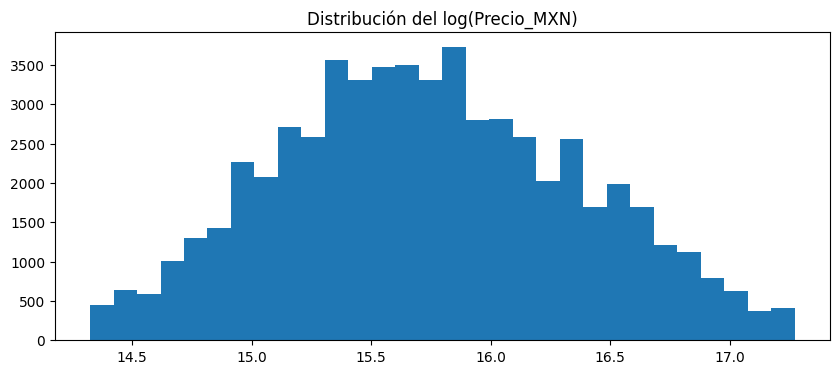

In [8]:
import numpy as np
import matplotlib.pyplot as plt
df_venta['Precio_log'] = np.log(df_venta['Precio_MXN'])
df_venta_log = np.log(df_venta['Precio_MXN'])

plt.figure(figsize=(10,4))
# plt.hist(df_venta['Precio_log'], bins=30)
# plt.title('Distribución del log(Precio_MXN)')
# plt.show()
plt.hist(df_venta_log, bins=30)
plt.title('Distribución del log(Precio_MXN)')
plt.show()


In [9]:
print(df_venta.head())
print('---'*15)
print(df_venta.info())
print('---'*15)
print(df_venta.describe())

                                           Direccion  Estacionamientos  \
0            Del Gas, Azcapotzalco, Ciudad de México               1.0   
2         Del Recreo, Azcapotzalco, Ciudad de México               1.0   
3            Del Gas, Azcapotzalco, Ciudad de México               2.0   
4            Del Gas, Azcapotzalco, Ciudad de México               1.0   
5  Azcapotzalco Centro, Azcapotzalco, Ciudad de M...               1.0   

   Precio_MXN  Superficie  Recamaras  Baños              Colonia  \
0   2586432.0        64.0        2.0    2.0              DEL GAS   
2   3400000.0       100.0        3.0    2.0           DEL RECREO   
3   3400000.0        78.0        3.0    2.0              DEL GAS   
4   2300000.0        60.0        2.0    1.0              DEL GAS   
5   2808291.0        52.0        2.0    1.0  AZCAPOTZALCO CENTRO   

      Municipio            Estado       Fecha  ... Hospitales Escuelas  \
0  AZCAPOTZALCO  DISTRITO FEDERAL  2025-07-01  ...        6.0    102.0  

In [10]:
# Matriz de correlación entre variables numericas
df_for_corr = df_venta[['Estacionamientos', 'Precio_MXN', 'Superficie', 'Recamaras', 'Baños', 'Seguridad', 'Balcon', 'Piscina', 'Jardin', 'Terraza', 'Hospitales', 'Escuelas', 'Esparcimiento', 'Restaurantes', 'Carpetas', 'Transporte', 'Precio_log']].copy()

numeric_X_with_price = df_for_corr.select_dtypes(include=['int64', 'float64', 'Float64'])
corr_matrix = numeric_X_with_price.corr()
print(corr_matrix)

                  Estacionamientos  Precio_MXN  Superficie  Recamaras  \
Estacionamientos          1.000000    0.310670    0.417712   0.316631   
Precio_MXN                0.310670    1.000000    0.608356   0.341262   
Superficie                0.417712    0.608356    1.000000   0.528655   
Recamaras                 0.316631    0.341262    0.528655   1.000000   
Baños                     0.344926    0.498702    0.547952   0.582634   
Hospitales               -0.291894   -0.096456   -0.323495  -0.332655   
Escuelas                 -0.391409   -0.263017   -0.471374  -0.447560   
Esparcimiento            -0.323222   -0.051506   -0.348330  -0.417100   
Restaurantes             -0.385545   -0.190926   -0.444415  -0.461834   
Carpetas                 -0.388878   -0.172043   -0.454263  -0.488567   
Transporte               -0.341356   -0.098750   -0.387168  -0.437165   
Precio_log                0.316480    0.937749    0.607641   0.356351   

                     Baños  Hospitales  Escuelas  

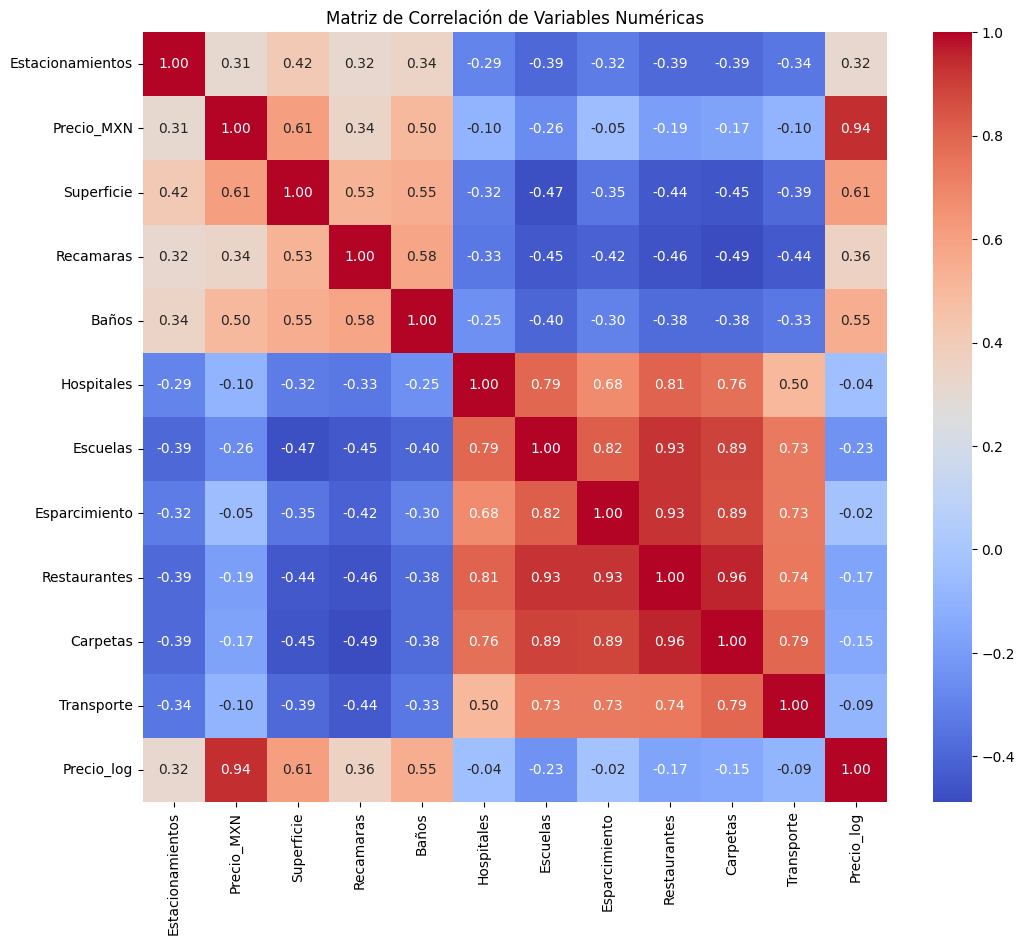

In [11]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [12]:
import os
import sys
import joblib
import warnings
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, make_scorer

import xgboost as xgb
import lightgbm as lgb

from scipy.stats import randint, uniform

RANDOM_STATE = 42

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def ensure_dense(X):
    """
    Convierte una matriz sparse a densa si tiene método toarray().
    Mantiene el array original si ya es denso.
    Esta función está definida a nivel de módulo para ser pickeable.
    """
    return X.toarray() if hasattr(X, "toarray") else X

def keep_top_k_categories(series: pd.Series, k: int):
    topk = series.value_counts().nlargest(k).index
    return series.where(series.isin(topk), other="Other")

def reduce_high_card_cols(df: pd.DataFrame, cols_topk_map: dict):
    df = df.copy()
    for col, k in cols_topk_map.items():
        if col in df.columns:
            df[col] = keep_top_k_categories(df[col].astype("object").fillna("Missing"), k)
    return df

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmse_mxn_from_log(y_log_true, y_log_pred):
    y_true_mxn = np.exp(y_log_true)
    y_pred_mxn = np.exp(y_log_pred)
    return rmse(y_true_mxn, y_pred_mxn)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mae_mxn_from_log(y_log_true, y_log_pred):
    y_true_mxn = np.exp(y_log_true)
    y_pred_mxn = np.exp(y_log_pred)
    return mae(y_true_mxn, y_pred_mxn)

def msle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)

def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(np.exp(y_true), np.exp(y_pred)))

neg_rmse_scorer = make_scorer(lambda y_true, y_pred: -rmse(y_true, y_pred), greater_is_better=True)

# Cargar datos
df = df_venta.copy()
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")


# Inspeccion rápida de nulos y columnas
print("\nNulos por columna:\n", df.isnull().sum())

TARGET = "Precio_log"
if TARGET not in df.columns:
    raise KeyError(f"No encuentro la columna target '{TARGET}' en el dataset.")

possible_leak_cols = [c for c in df.columns if c.lower() in ("precio_mxn", "precio_mx", "precio", "price_mxn", "precio_m") and c != TARGET]
if possible_leak_cols:
    for c in possible_leak_cols:
        df = df.drop(columns=[c])

if "Precio_MXN" in df.columns:
    df = df.drop(columns=["Precio_MXN"])

# Limpieza y tipado de columnas booleanas
bool_cols = ["Seguridad", "Balcon", "Piscina", "Jardin", "Terraza"]
for c in bool_cols:
    if c in df.columns:
        df[c] = df[c].map({True: 1, False: 0, "True": 1, "False": 0}).astype("Float64")

# Top-k para categorías de alta cardinalidad
cols_topk_map = {c: 50 for c in ["Colonia", "Municipio", "Estado", "Tipo"] if c in df.columns}
if cols_topk_map:
    df = reduce_high_card_cols(df, cols_topk_map)

# Preparar X,y y split
X = df.drop(columns=[TARGET])
y = df[TARGET].values

for col in ["Direccion", "Fecha", "Web"]:
    if col in X.columns:
        X = X.drop(columns=[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

# Columnas numericas y categoricas
numeric_cols = X_train.select_dtypes(include=["int64", "float64", "Float64"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("\nNuméricos:", numeric_cols)
print("Categóricos:", categorical_cols)

# Pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# detectar la firma correcta para OneHotEncoder (sparse_output vs sparse)
ohe_kwargs = {"handle_unknown": "ignore"}
try:
    OneHotEncoder(sparse_output=False, **ohe_kwargs)
    ohe_use = {"sparse_output": False}
except TypeError:
    ohe_use = {"sparse": False}

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(**ohe_use, handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols),
], remainder="drop")

to_dense = FunctionTransformer(ensure_dense, accept_sparse=True)

# Modelos y espacios de busqueda
models_and_params = {
    "LinearRegression": {
        "model": Pipeline([("pre", preprocessor), ("model", LinearRegression())]),
        "params": {}
    },
    "Ridge": {
        "model": Pipeline([("pre", preprocessor), ("model", Ridge(random_state=RANDOM_STATE))]),
        "params": {
            "model__alpha": uniform(0.1, 10.0)
        }
    },
    "Lasso": {
        "model": Pipeline([("pre", preprocessor), ("model", Lasso(random_state=RANDOM_STATE, max_iter=5000))]),
        "params": {
            "model__alpha": uniform(1e-4, 1.0)
        }
    },
    "RandomForest": {
        "model": Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))]),
        "params": {
            "model__n_estimators": randint(50, 200),
            "model__max_depth": randint(4, 20),
            "model__min_samples_split": randint(2, 10),
            "model__min_samples_leaf": randint(1, 5)
        }
    },
    "HistGradientBoosting": {
        "model": Pipeline([("pre", preprocessor), ("todense", to_dense),
                           ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))]),
        "params": {
            "model__max_iter": randint(100, 400),
            "model__learning_rate": uniform(0.01, 0.3),
            "model__max_depth": randint(3, 15)
        }
    },
    "XGBoost": {
        "model": Pipeline([("pre", preprocessor), ("model", xgb.XGBRegressor(objective='reg:squarederror',
                                                                            random_state=RANDOM_STATE,
                                                                            n_jobs=-1))]),
        "params": {
            "model__n_estimators": randint(50, 300),
            "model__learning_rate": uniform(0.01, 0.3),
            "model__max_depth": randint(3, 10),
            "model__subsample": uniform(0.6, 0.4),
            "model__colsample_bytree": uniform(0.6, 0.4)
        }
    },
    "LightGBM": {
        "model": Pipeline([("pre", preprocessor), ("model", lgb.LGBMRegressor(objective='regression_l1',
                                                                            random_state=RANDOM_STATE,
                                                                            n_jobs=-1))]),
        "params": {
            "model__n_estimators": randint(50, 300),
            "model__learning_rate": uniform(0.01, 0.3),
            "model__max_depth": randint(3, 10),
            "model__subsample": uniform(0.6, 0.4),
            "model__colsample_bytree": uniform(0.6, 0.4)
        }
    }
}

# Entrenamiento, busqueda y evaluacion
results = []
cv_outer = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, mp in models_and_params.items():
    print(f"\n----- MODELO: {name} -----")
    pipeline = mp["model"]
    params = mp["params"]

    if params:
        n_iter = 25
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=params,
            n_iter=n_iter,
            scoring=neg_rmse_scorer,
            cv=3,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            refit=True,
            verbose=1,
            error_score="raise"
        )
        search.fit(X_train, y_train)
        best_est = search.best_estimator_
        print(f"Mejores params: {search.best_params_}")
        cvs = -cross_val_score(best_est, X_train, y_train, cv=cv_outer,
                               scoring=neg_rmse_scorer, n_jobs=-1)
        mean_cv_rmse_log = cvs.mean()
        std_cv_rmse_log = cvs.std()
        trained_model = best_est
    else:
        scores = -cross_val_score(pipeline, X_train, y_train, cv=cv_outer,
                                  scoring=neg_rmse_scorer, n_jobs=-1)
        mean_cv_rmse_log = scores.mean()
        std_cv_rmse_log = scores.std()
        pipeline.fit(X_train, y_train)
        trained_model = pipeline

    y_pred_log_test = trained_model.predict(X_test)
    y_pred_log_train = trained_model.predict(X_train)

    test_rmse_log = rmse(y_test, y_pred_log_test)
    train_rmse_log = rmse(y_train, y_pred_log_train)
    test_r2 = r2_score(y_test, y_pred_log_test)
    test_mae_log = mae(y_test, y_pred_log_test)
    train_mae_log = mae(y_train, y_pred_log_train)
    test_rmsle_mxn = rmsle(y_test, y_pred_log_test)
    train_rmsle_mxn = rmsle(y_train, y_pred_log_train)


    test_rmse_mxn = rmse_mxn_from_log(y_test, y_pred_log_test)
    train_rmse_mxn = rmse_mxn_from_log(y_train, y_pred_log_train)
    test_mae_mxn = mae_mxn_from_log(y_test, y_pred_log_test)
    train_mae_mxn = mae_mxn_from_log(y_train, y_pred_log_train)

    print(f"RMSE (log) - Train: {train_rmse_log:.4f} | Test: {test_rmse_log:.4f}")
    print(f"RMSE (MXN) - Train: {train_rmse_mxn:,.0f} | Test: {test_rmse_mxn:,.0f}")
    print(f"MAE (log) - Train: {train_mae_log:.4f} | Test: {test_mae_log:.4f}")
    print(f"MAE (MXN) - Train: {train_mae_mxn:,.0f} | Test: {test_mae_mxn:,.0f}")
    print(f"RMSLE (MXN) - Train: {train_rmsle_mxn:.4f} | Test: {test_rmsle_mxn:.4f}")
    print(f"R2 (test): {test_r2:.4f}")


    fname = f"best_model_{name}.joblib"
    joblib.dump(trained_model, fname)
    print(f"Modelo guardado: {fname}")

    feature_importances = None
    try:
        pre = trained_model.named_steps.get("pre", None)
        if pre is not None and hasattr(pre, "transformers_"):
            feature_names = []
            for name_t, transformer, cols in pre.transformers_:
                if name_t == "num":
                    feature_names.extend(cols)
                elif name_t == "cat":
                    ohe = transformer.named_steps.get("ohe", None)
                    if ohe is not None and hasattr(ohe, "get_feature_names_out"):
                        cat_names = ohe.get_feature_names_out(cols)
                        feature_names.extend(cat_names.tolist())
                    else:
                        feature_names.extend(cols)
            model_step = trained_model.named_steps.get("model", None)
            if model_step is not None and hasattr(model_step, "feature_importances_"):
                fi = model_step.feature_importances_
                if len(fi) == len(feature_names):
                    feature_importances = sorted(zip(feature_names, fi), key=lambda x: -x[1])[:30]
    except Exception:
        pass

    if feature_importances:
        print(f"Top features (modelo {name}):")
        for feat, val in feature_importances[:10]:
            print(f"  {feat}: {val:.4f}")

    results.append({
        "model": name,
        "mean_cv_rmse_log": mean_cv_rmse_log,
        "std_cv_rmse_log": std_cv_rmse_log,
        "train_rmse_log": train_rmse_log,
        "test_rmse_log": test_rmse_log,
        "train_mae_log": train_mae_log,
        "test_mae_log": test_mae_log,
        "train_rmsle_mxn": train_rmsle_mxn,
        "test_rmsle_mxn": test_rmsle_mxn,
        "train_rmse_mxn": train_rmse_mxn,
        "test_rmse_mxn": test_rmse_mxn,
        "train_mae_mxn": train_mae_mxn,
        "test_mae_mxn": test_mae_mxn,
        "test_r2": test_r2,
        "model_file": fname
    })

# Resumen y guardado
df_results = pd.DataFrame(results).sort_values("test_rmse_log")
print("\n===== Resumen de resultados (ordenado por test_rmse_log) =====")
print(df_results[["model", "test_rmse_log", "test_rmse_mxn", "test_mae_log", "test_mae_mxn", "test_rmsle_mxn", "test_r2"]])

df_results.to_csv("resultados_experimentacion_corregido_v2.csv", index=False)
print("\nResumen guardado en 'resultados_experimentacion_corregido_v2.csv'")

Dataset loaded: 58629 rows, 27 columns

Nulos por columna:
 Direccion               0
Estacionamientos        0
Precio_MXN              0
Superficie              0
Recamaras               0
Baños                   0
Colonia                 0
Municipio               0
Estado                  0
Fecha                   0
Seguridad            7341
Balcon               7341
Piscina              7341
Jardin               7341
Terraza              7341
Tipo                  803
Web                     0
Hospitales          12705
Escuelas            12705
Esparcimiento       12705
Restaurantes        12705
Carpetas            12705
Transporte          12705
Parques             13408
Latitud             12708
Longitud            12708
Precio_log              0
dtype: int64

Train: (46903, 22), Test: (11726, 22)

Numéricos: ['Estacionamientos', 'Superficie', 'Recamaras', 'Baños', 'Seguridad', 'Balcon', 'Piscina', 'Jardin', 'Terraza', 'Hospitales', 'Escuelas', 'Esparcimiento', 'Restaurantes', 'Ca

In [16]:
print(df_results.sort_values("test_r2", ascending=False))

                  model  mean_cv_rmse_log  std_cv_rmse_log  train_rmse_log  \
5               XGBoost          0.292499         0.003254        0.227154   
3          RandomForest          0.301833         0.004007        0.221935   
4  HistGradientBoosting          0.299294         0.003876        0.255947   
6              LightGBM          0.305840         0.004982        0.280828   
0      LinearRegression          0.359086         0.003269        0.357942   
1                 Ridge          0.359049         0.003308        0.357964   
2                 Lasso          0.406777         0.003834        0.406731   

   test_rmse_log  train_mae_log  test_mae_log  train_rmsle_mxn  \
5       0.288070       0.164606      0.203870         0.227154   
3       0.293971       0.153037      0.201302         0.221935   
4       0.294239       0.184559      0.209285         0.255947   
6       0.301032       0.187619      0.208073         0.280828   
0       0.356143       0.268697      0.267842

In [17]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


```
----- MODELO: MLPRegressor -----
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Mejores params: {'model__activation': 'tanh', 'model__alpha': np.float64(0.000621653160488281), 'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': np.float64(0.004419450186421158), 'model__max_iter': 760, 'model__solver': 'adam'}
RMSE (log) - Train: 0.3177 | Test: 0.3292
RMSE (MXN) - Train: 3,096,195 | Test: 3,239,227
MAE (log) - Train: 0.2390 | Test: 0.2479
MAE (MXN) - Train: 2,015,707 | Test: 2,108,436
RMSLE (MXN) - Train: 0.3177 | Test: 0.3292
R2 (test): 0.7258
Modelo guardado: best_model_MLPRegressor.joblib

----- MODELO: CatBoostRegressor -----
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Mejores params: {'model__border_count': 91, 'model__depth': 9, 'model__iterations': 100, 'model__l2_leaf_reg': np.float64(4.824619912671627), 'model__learning_rate': np.float64(0.3049692657420365), 'model__loss_function': 'RMSE'}
RMSE (log) - Train: 0.2800 | Test: 0.3012
RMSE (MXN) - Train: 2,877,436 | Test: 3,088,270
MAE (log) - Train: 0.2061 | Test: 0.2191
MAE (MXN) - Train: 1,762,974 | Test: 1,887,437
RMSLE (MXN) - Train: 0.2800 | Test: 0.3012
R2 (test): 0.7705
Modelo guardado: best_model_CatBoostRegressor.joblib
Top features (modelo CatBoostRegressor):
  Superficie: 24.1063
  Baños: 12.4153
  Latitud: 9.1330
  Longitud: 7.1740
  Esparcimiento: 4.9065
  Colonia_Other: 4.2287
  Escuelas: 3.9141
  Tipo_Departamento: 3.4947
  Estado_DISTRITO FEDERAL: 2.9838
  Restaurantes: 2.8326

```

